In [154]:
!pip install torch torchvision


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, trange

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class WatermarkSegmentationNet(nn.Module):
    def __init__(self):
        super(WatermarkSegmentationNet, self).__init__()
        # Load a pre-trained ResNet model
        resnet = models.resnet34(pretrained=True)

        # Use the layers of ResNet as the encoder
        self.encoder_layers = nn.Sequential(*list(resnet.children())[:-2])  # Remove the last two layers (avgpool and fc)
        
        # Decoder layers
        self.upconv1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv5 = self.double_conv(512, 256)  # Define conv5 layer
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv6 = self.double_conv(256, 128)  # Define conv6 layer
        self.upconv3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv7 = self.double_conv(128, 64)  # Define conv7 layer
        self.final_conv = nn.Conv2d(64, 1, 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x):
        # Encoder (ResNet layers)
        x1 = self.encoder_layers[0](x)
        x1 = self.encoder_layers[1](x1)
        x2 = self.encoder_layers[4](x1)
        x3 = self.encoder_layers[5](x2)
        x4 = self.encoder_layers[6](x3)
        x5 = self.encoder_layers[7](x4)

        # Decoder
        x = self.upconv1(x5)  # Upsample
        x = torch.cat([x, self.center_crop(x4, x.size()[2:])], dim=1)
        x = F.relu(self.conv5(x))

        x = self.upconv2(x)  # Upsample
        x = torch.cat([x, self.center_crop(x3, x.size()[2:])], dim=1)
        x = F.relu(self.conv6(x))

        x = self.upconv3(x)  # Upsample
        x = torch.cat([x, self.center_crop(x2, x.size()[2:])], dim=1)
        x = F.relu(self.conv7(x))

        # Ensure the final output is of the correct size
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        out = self.final_conv(x)
        return torch.sigmoid(out)

In [157]:
X = np.load(os.path.join('data/dataset/x_data_watermarked.npy'))  # Input images
Y = np.load(os.path.join('data/dataset/y_data_watermarked.npy'))  # Target masks

# Convert the NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X.transpose((0, 3, 1, 2)), dtype=torch.float32)  # Convert to NCHW format
Y_tensor = torch.tensor(Y, dtype=torch.float32)

In [158]:
# normalize
X_tensor /= 255.0
Y_tensor /= 255.0

In [159]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class WatermarkDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask.unsqueeze(0)  # Add channel dimension to mask

In [160]:
# is the gpu utilized?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [163]:
# Create the dataset and data loader
dataset = WatermarkDataset(X_tensor, Y_tensor)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model, loss function, and optimizer
model = WatermarkSegmentationNet().to(device)
for param in model.encoder_layers.parameters():
    param.requires_grad = False
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    for images, masks in tqdm(data_loader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 250/250 [00:40<00:00,  6.12it/s]


Epoch 1/5, Loss: 0.05293818935751915


100%|██████████| 250/250 [00:40<00:00,  6.15it/s]


Epoch 2/5, Loss: 0.044390399008989334


100%|██████████| 250/250 [00:39<00:00,  6.26it/s]


Epoch 3/5, Loss: 0.034650806337594986


100%|██████████| 250/250 [00:39<00:00,  6.27it/s]


Epoch 4/5, Loss: 0.019566131755709648


100%|██████████| 250/250 [00:41<00:00,  5.99it/s]

Epoch 5/5, Loss: 0.043237924575805664


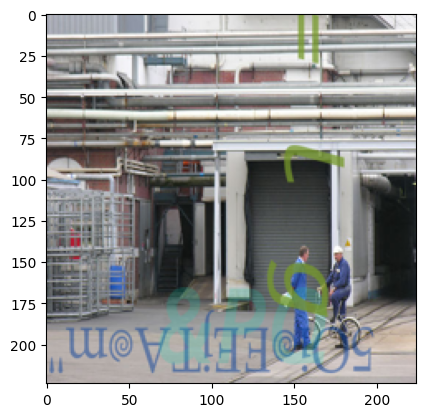

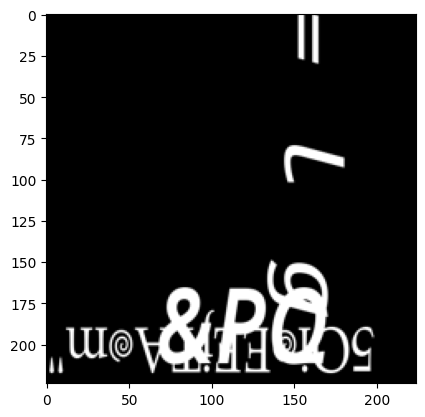

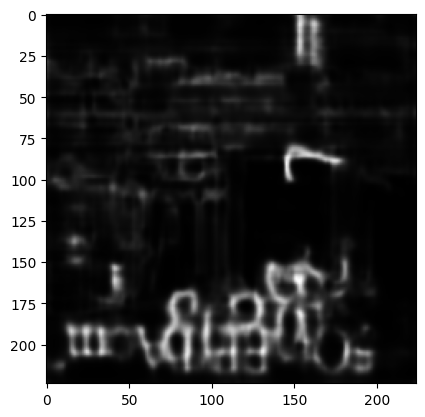

In [174]:
k = 68

# display first image from the dataset
plt.imshow(X[k])
plt.show()

# display first mask from the dataset
plt.imshow(Y[k], cmap='gray')
plt.show()

# display first prediction from the dataset
plt.imshow(model(X_tensor[k].unsqueeze(0).to(device)).squeeze().cpu().detach().numpy(), cmap='gray')
plt.show()